In [1]:
from __future__ import annotations
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import graphviz
from sklearn.linear_model import LassoCV
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Maint hours:\n", pd.read_csv("./data/PdM_maint.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())
print("Fail hours:\n",  pd.read_csv("./data/PdM_failures.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())
print("Err hours:\n",   pd.read_csv("./data/PdM_errors.csv", parse_dates=["datetime"])["datetime"].dt.hour.value_counts().sort_index())

Maint hours:
 6    3286
Name: datetime, dtype: int64
Fail hours:
 3     18
6    743
Name: datetime, dtype: int64
Err hours:
 0      126
1      132
2      142
3      112
4      127
5      117
6     1122
7      119
8      135
9      113
10     124
11      98
12     120
13     130
14     128
15     129
16     113
17     124
18     127
19     108
20     127
21     108
22     116
23     122
Name: datetime, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def visualize_data(
    telemetry_path: str,
    errors_path: str,
    failures_path: str,
    maint_path: str,
    machines_path: str,
    machine_model: str = None,
    failure_type: str = None,
    window_hours: int = 48,
    n_examples: int = 3,
    ylim_sigma: int = 5,
    smooth_window: int = 6,
    scale: bool = True  # <--- NEW: Toggle Z-Scores vs Raw Units
):
    print("Loading data...")
    tele = pd.read_csv(telemetry_path, parse_dates=["datetime"])
    errors = pd.read_csv(errors_path, parse_dates=["datetime"])
    fails = pd.read_csv(failures_path, parse_dates=["datetime"])
    maint = pd.read_csv(maint_path, parse_dates=["datetime"])
    machines = pd.read_csv(machines_path)

    if machine_model:
        target_mids = machines[machines["model"] == machine_model]["machineID"]
        fails = fails[fails["machineID"].isin(target_mids)]
    
    if failure_type:
        fails = fails[fails["failure"] == failure_type]

    if fails.empty:
        print("No failures found.")
        return

    sample_failures = fails.sample(n=min(n_examples, len(fails)), random_state=12345678)
    sensor_cols = ["volt", "rotate", "pressure", "vibration"]

    for idx, row in sample_failures.iterrows():
        mid = row["machineID"]
        fail_dt = row["datetime"]
        fail_comp = row["failure"]
        model = machines[machines["machineID"]==mid]["model"].values[0]

        # --- DATA PREP ---
        # Get full history to calculate baseline statistics
        machine_tele = tele[tele["machineID"] == mid].copy().sort_values("datetime")
        
        # Calculate stats for this specific machine
        stats = {}
        for col in sensor_cols:
            mu = machine_tele[col].mean()
            sigma = machine_tele[col].std()
            stats[col] = {'mean': mu, 'std': sigma}
            
            # Apply Scaling if requested
            if scale:
                machine_tele[col] = (machine_tele[col] - mu) / sigma

            # Create Smooth Column (on top of whatever units we are using)
            machine_tele[f"{col}_smooth"] = machine_tele[col].rolling(window=smooth_window, center=True).mean()

        # Slice Window
        start_time = fail_dt - pd.Timedelta(hours=window_hours)
        end_time = fail_dt + pd.Timedelta(hours=window_hours)
        
        window_tele = machine_tele[machine_tele["datetime"].between(start_time, end_time)]
        window_errors = errors[(errors["machineID"] == mid) & (errors["datetime"].between(start_time, end_time))]
        window_maint = maint[(maint["machineID"] == mid) & (maint["datetime"].between(start_time, end_time))]

        if window_tele.empty: continue

        # --- PLOTTING ---
        unit_label = "Z-Score" if scale else "Raw Units"
        fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)
        fig.suptitle(
            f"Machine {mid} ({model}): {fail_comp} at {fail_dt}\n"
            f"Scale: {unit_label} (Fixed +/- {ylim_sigma}σ) | Trend: {smooth_window}h Avg", 
            fontsize=16
        )

        for i, sensor in enumerate(sensor_cols):
            ax = axes[i]
            
            # 1. Plot Raw & Smooth
            sns.lineplot(data=window_tele, x="datetime", y=sensor, ax=ax, color='gray', alpha=0.2, linewidth=0.8)
            sns.lineplot(data=window_tele, x="datetime", y=f"{sensor}_smooth", ax=ax, color='tab:blue', linewidth=2.5)
            
            # 2. Smart Y-Axis Limits
            # If scale=True, center is 0. If scale=False, center is Mean.
            center = 0 if scale else stats[sensor]['mean']
            std_dev = 1 if scale else stats[sensor]['std']
            
            lower_limit = center - (ylim_sigma * std_dev)
            upper_limit = center + (ylim_sigma * std_dev)
            
            ax.set_ylim(lower_limit, upper_limit)

            # 3. Visual Guides (Normal Range = +/- 2 Sigma)
            norm_lower = center - (2 * std_dev)
            norm_upper = center + (2 * std_dev)
            ax.axhspan(norm_lower, norm_upper, color='green', alpha=0.05, label="Normal (2σ)")
            ax.axhline(center, color='green', linestyle=':', alpha=0.5)

            # 4. 6:00 AM Grid
            six_ams = pd.date_range(start=start_time, end=end_time, freq="D") + pd.Timedelta(hours=6)
            for t in six_ams:
                ax.axvline(t, color='gray', linestyle=':', alpha=0.3)

            # 5. Stacked Error Labels
            if not window_errors.empty:
                err_points = pd.merge_asof(
                    window_errors.sort_values('datetime'), 
                    window_tele[['datetime', f"{sensor}_smooth"]], 
                    on='datetime', direction='nearest'
                )
                
                # Markers
                ax.scatter(err_points['datetime'], err_points[f"{sensor}_smooth"], 
                           color='red', s=60, zorder=5, marker='X')

                # Text Labels
                for dt, group in err_points.groupby('datetime'):
                    y_val = group[f"{sensor}_smooth"].iloc[0]
                    if pd.notna(y_val) and lower_limit < y_val < upper_limit:
                        labels = sorted(group['errorID'].apply(lambda s: s.replace("error", "E")).unique())
                        label_text = " / ".join(labels)
                        
                        ax.text(
                            dt, y_val + (0.6 * std_dev), # Smart offset based on unit scale
                            label_text, 
                            color='red', fontweight='bold', fontsize=10, ha='center',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                        )

            # 6. Maint / Failure
            for m_date in window_maint['datetime']:
                ax.axvline(m_date, color='green', linestyle='--', linewidth=2, label='Maint.')
            ax.axvline(fail_dt, color='red', linestyle='-', linewidth=2, label='FAILURE')

            ax.set_ylabel(f"{sensor.title()}\n({unit_label})")
            if i == 0:
                ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.show()



=== Visualizing for model1 - comp1 ===
Loading data...


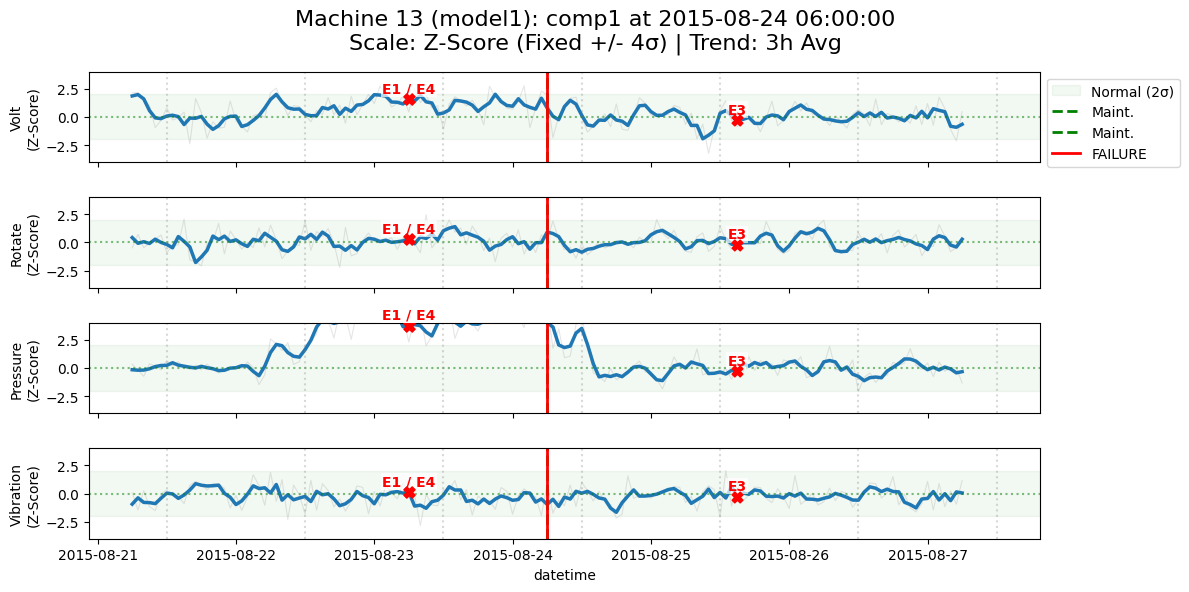



=== Visualizing for model1 - comp2 ===
Loading data...


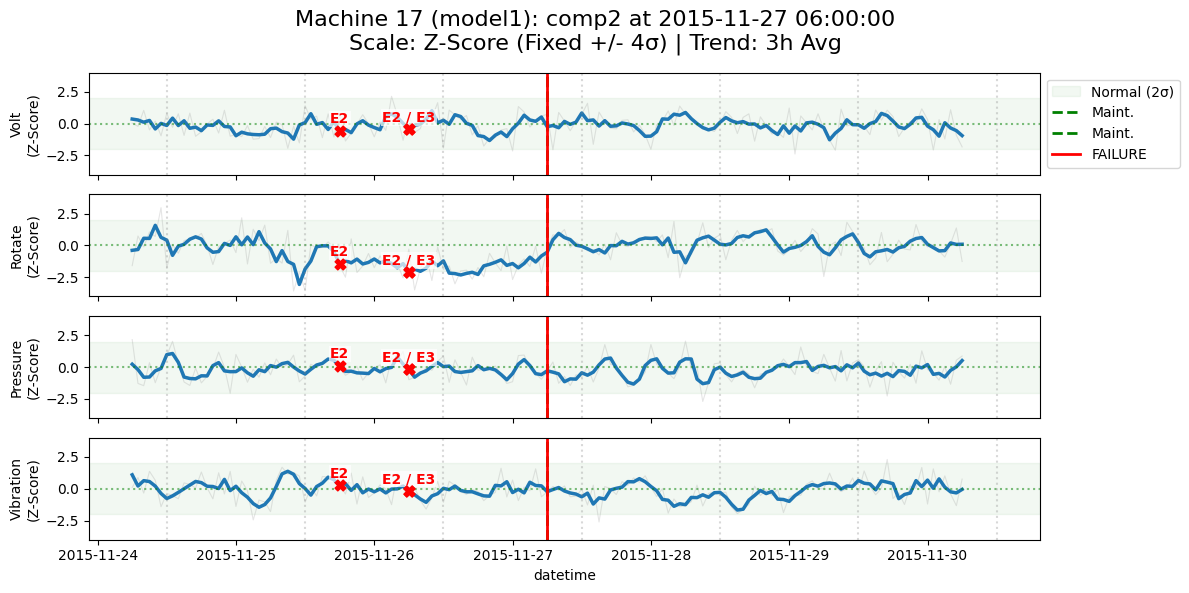



=== Visualizing for model1 - comp3 ===
Loading data...


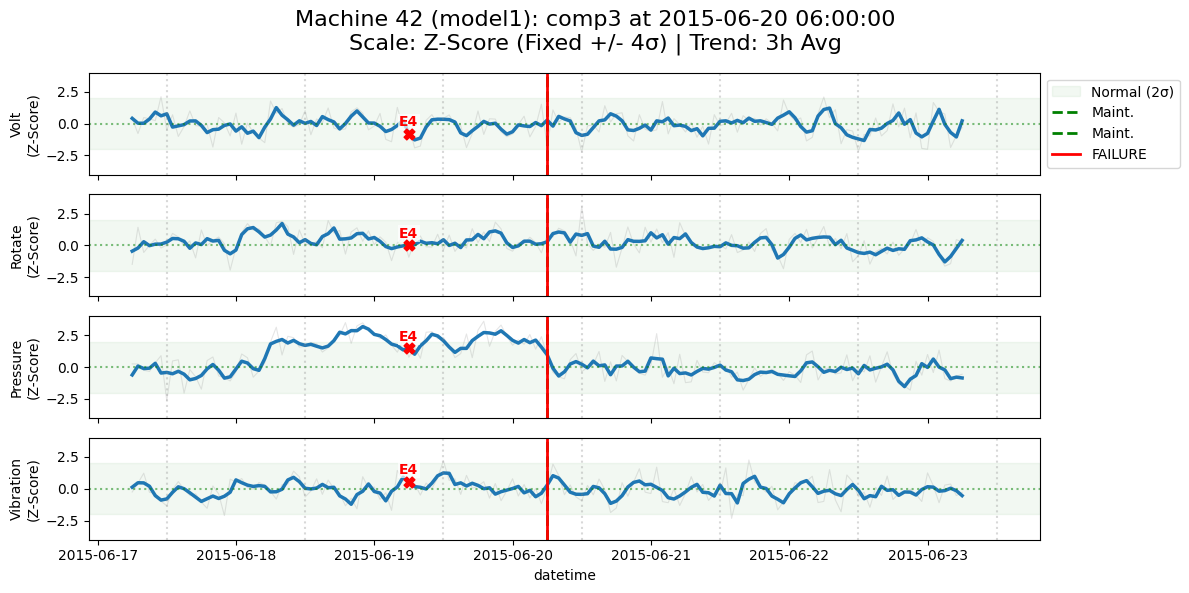



=== Visualizing for model1 - comp4 ===
Loading data...


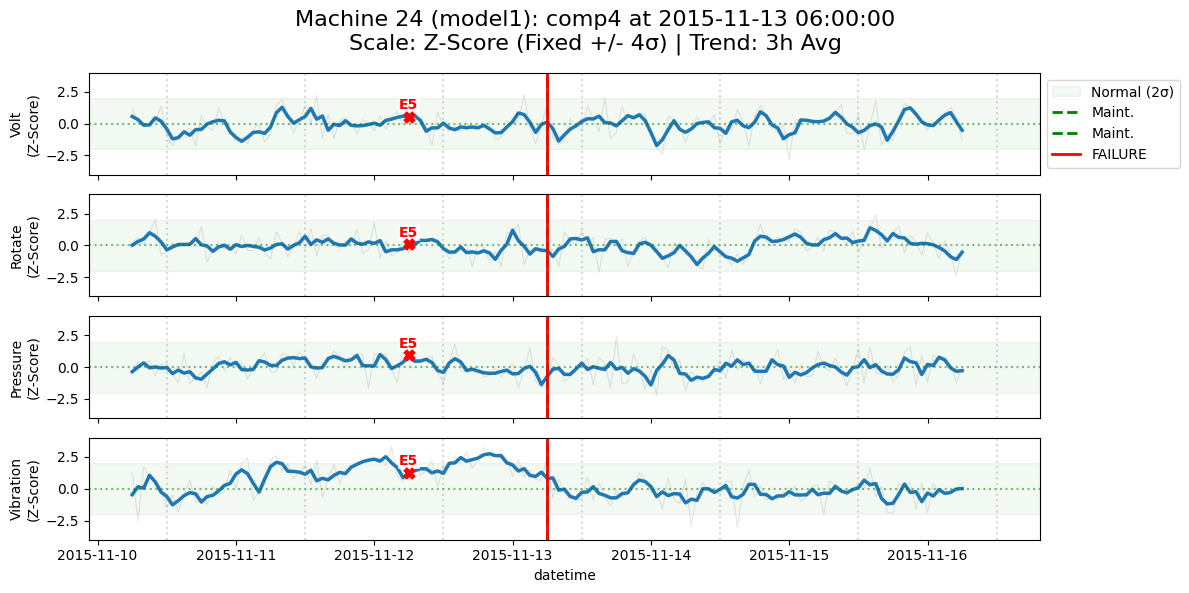



=== Visualizing for model2 - comp1 ===
Loading data...


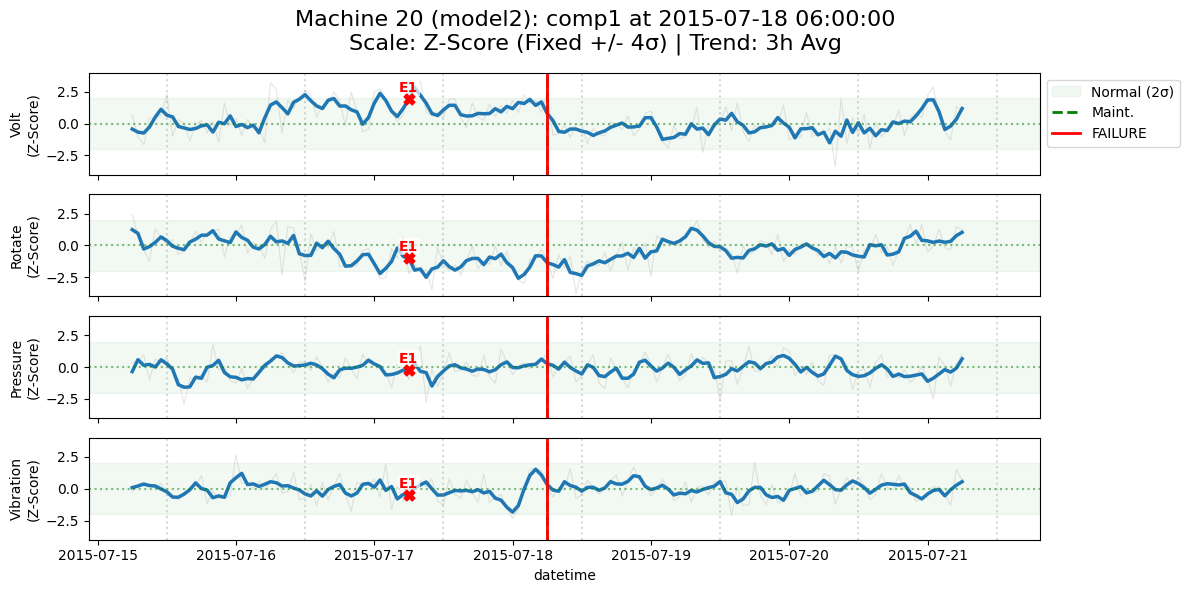



=== Visualizing for model2 - comp2 ===
Loading data...


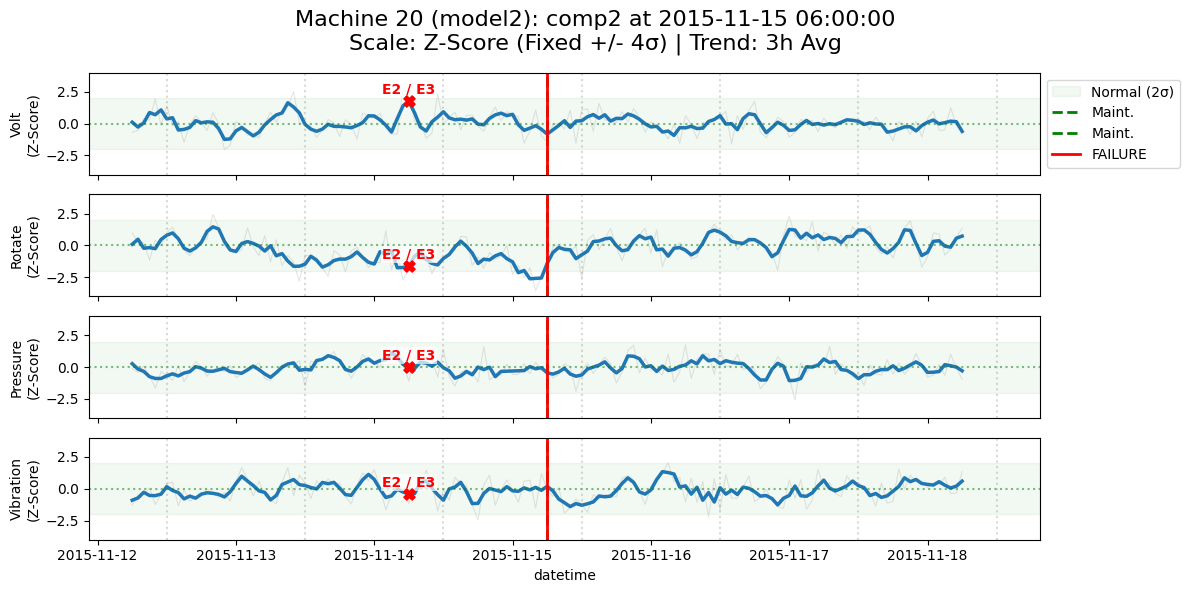



=== Visualizing for model2 - comp3 ===
Loading data...


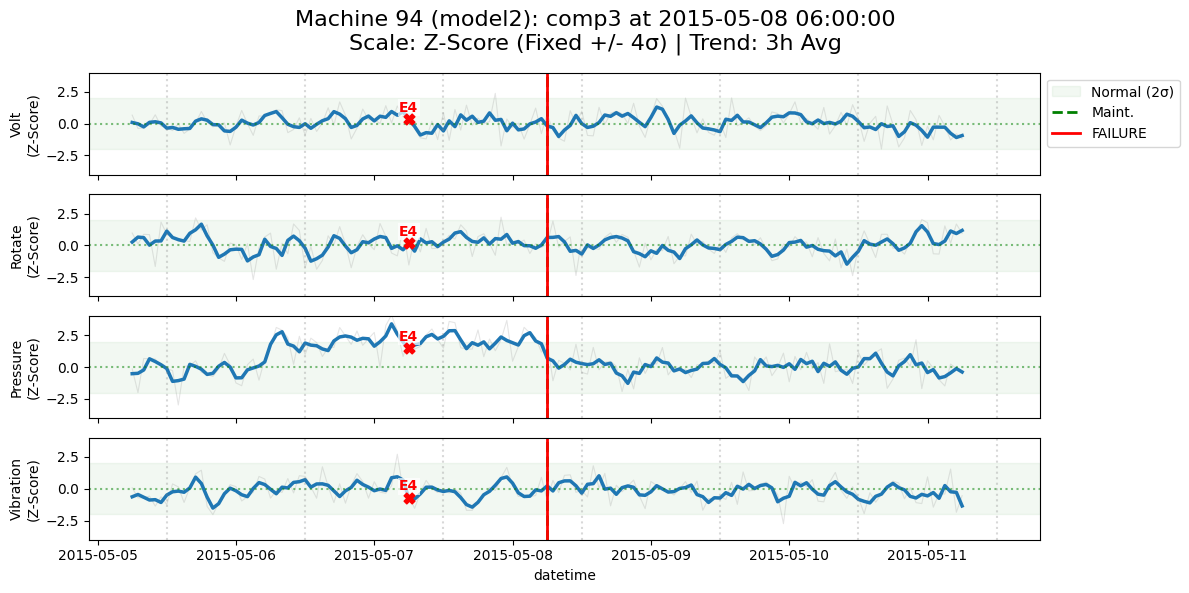



=== Visualizing for model2 - comp4 ===
Loading data...


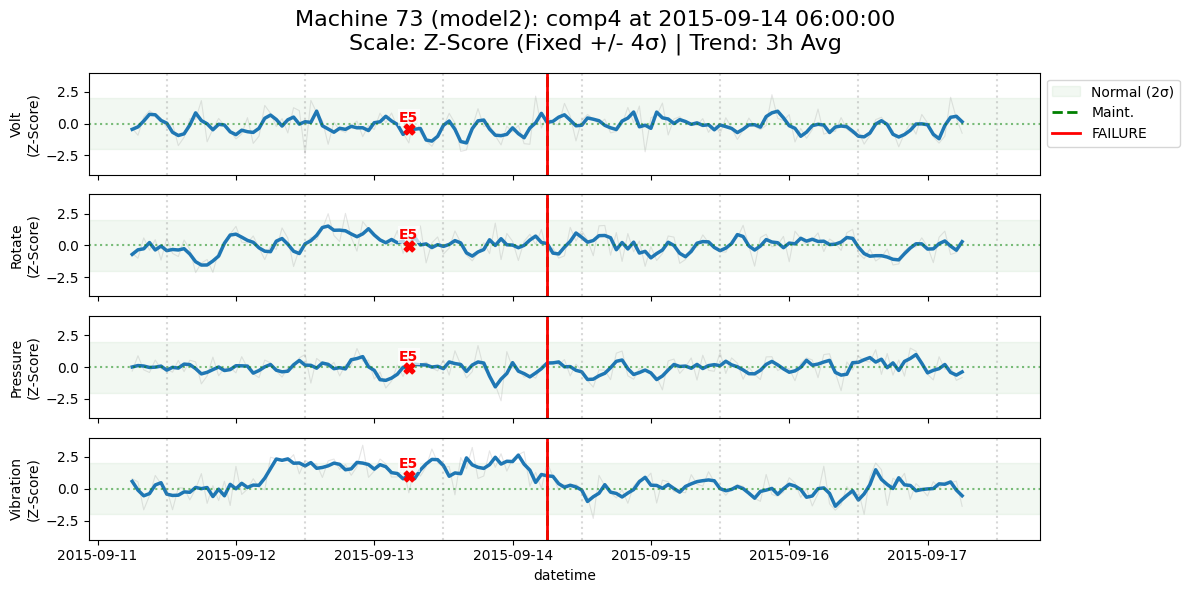



=== Visualizing for model3 - comp1 ===
Loading data...


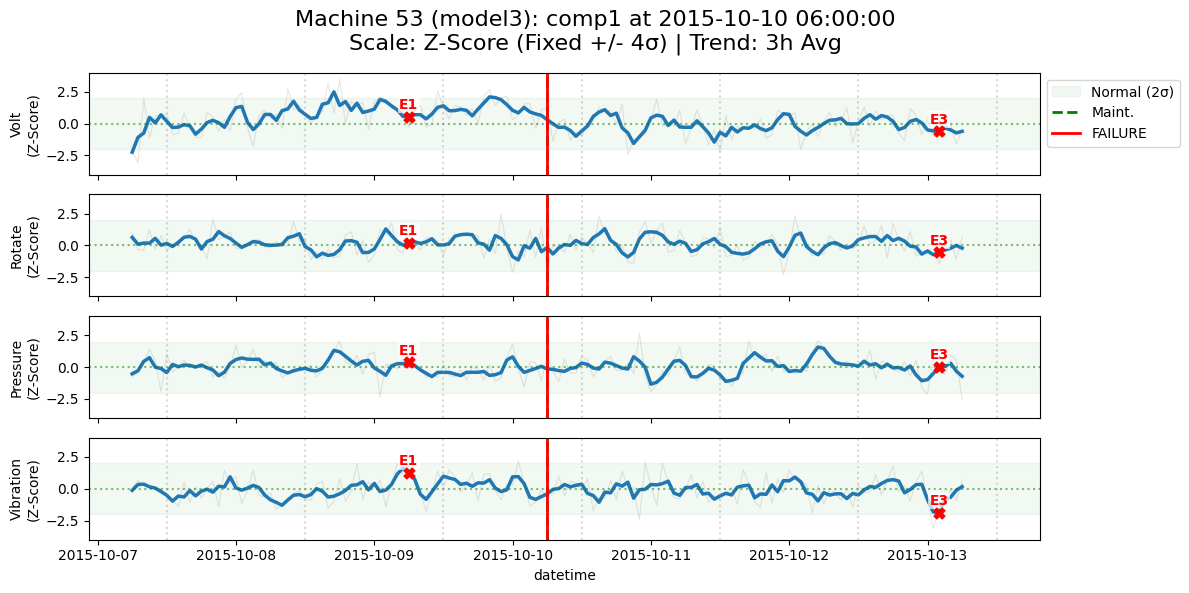



=== Visualizing for model3 - comp2 ===
Loading data...


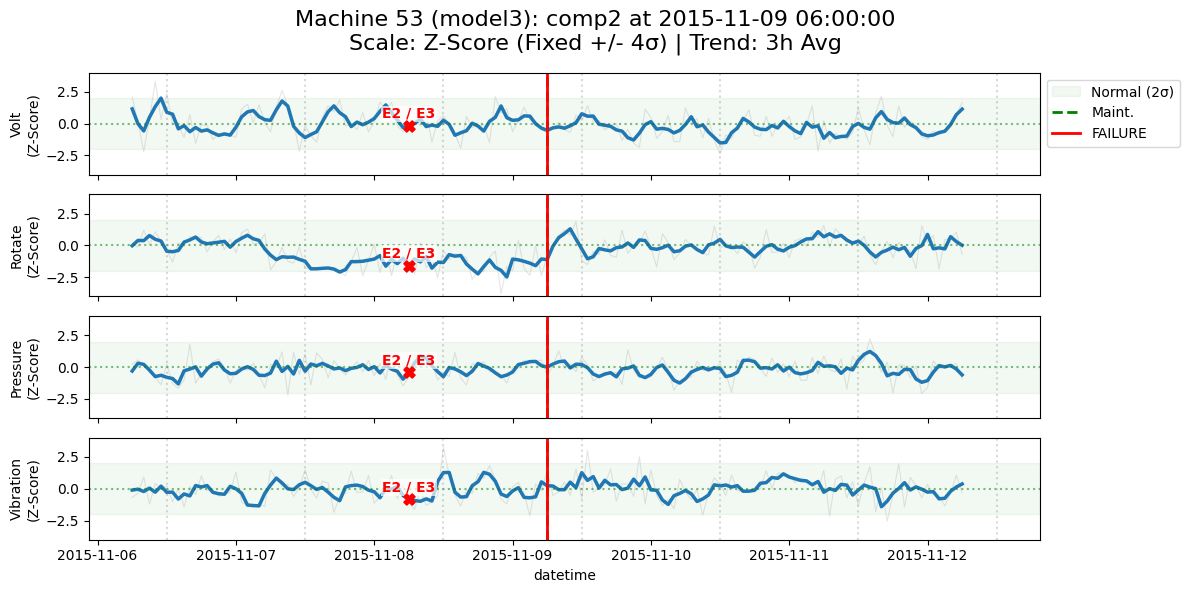



=== Visualizing for model3 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model3 - comp4 ===
Loading data...


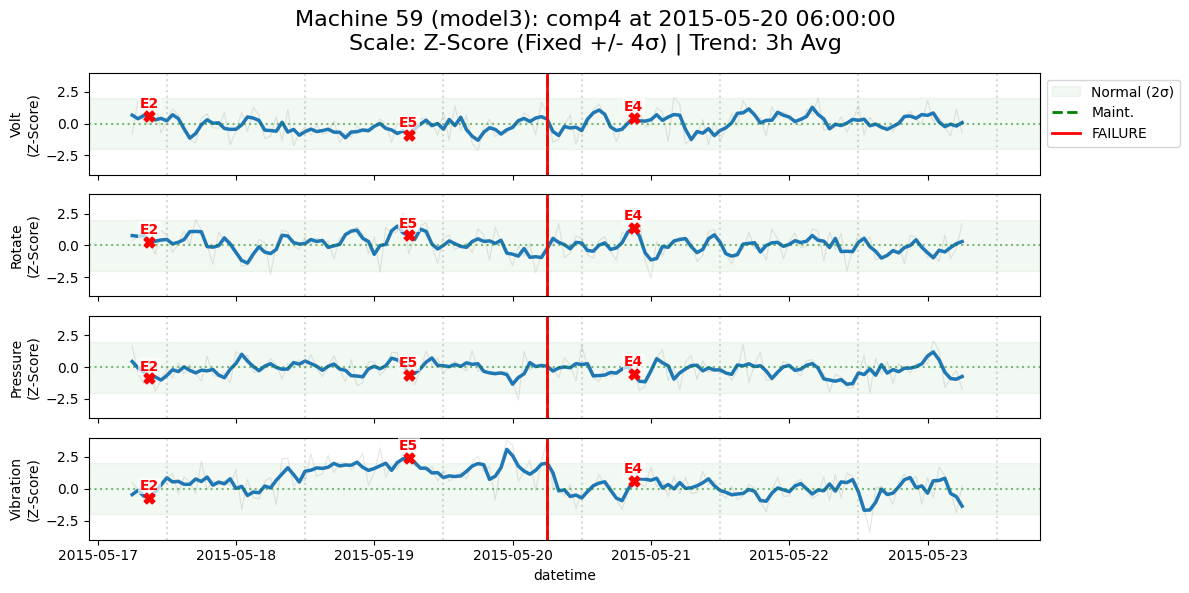



=== Visualizing for model4 - comp1 ===
Loading data...


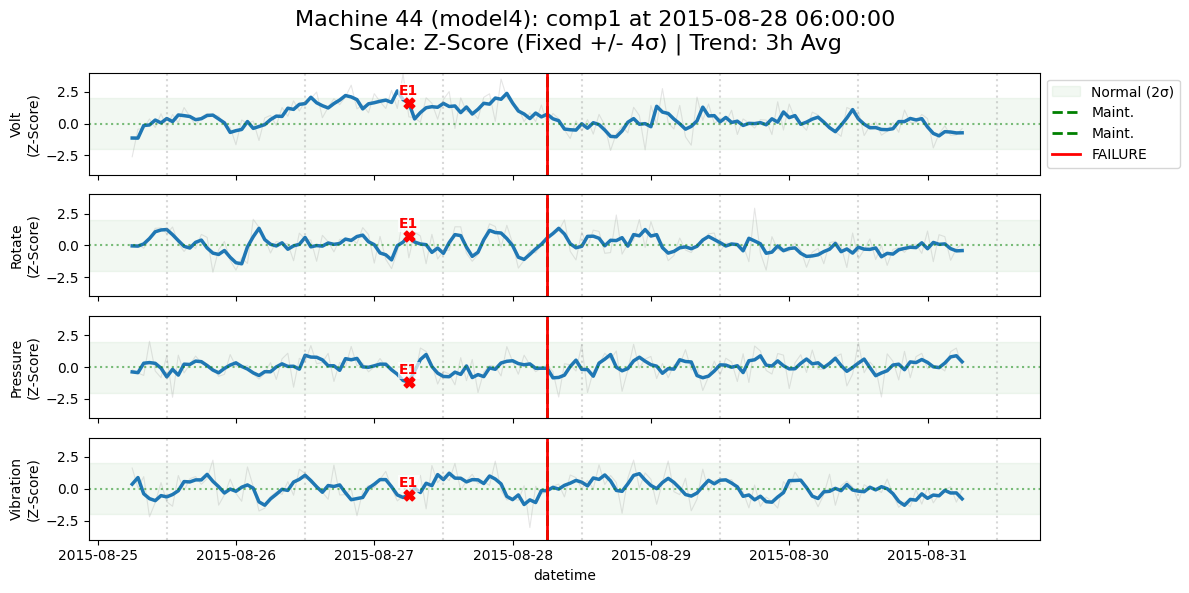



=== Visualizing for model4 - comp2 ===
Loading data...


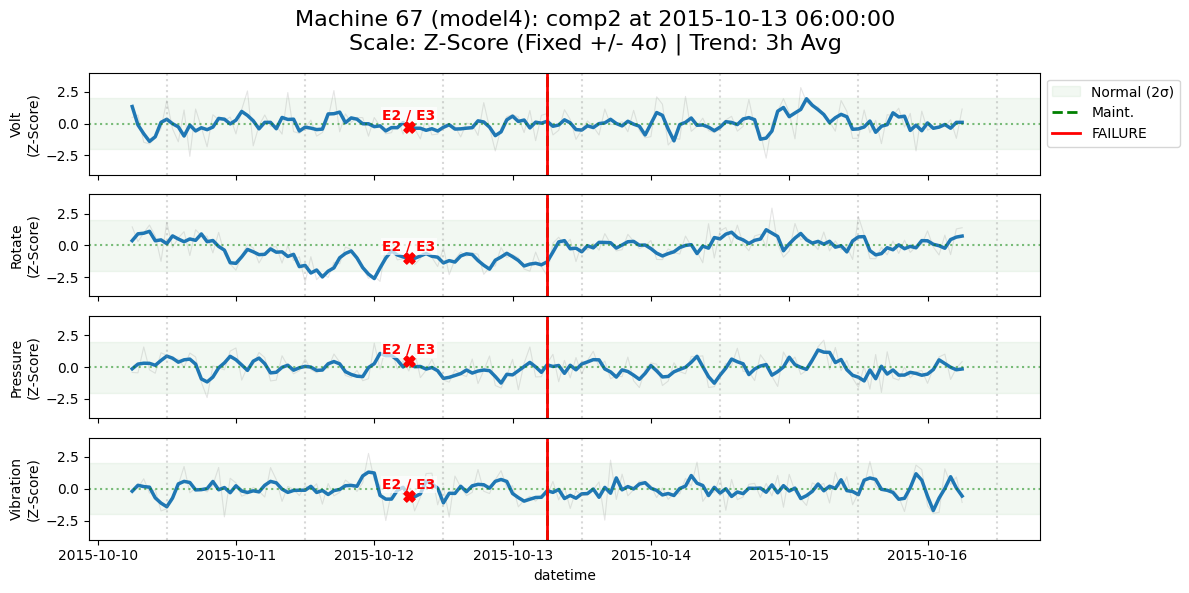



=== Visualizing for model4 - comp3 ===
Loading data...
No failures found.


=== Visualizing for model4 - comp4 ===
Loading data...


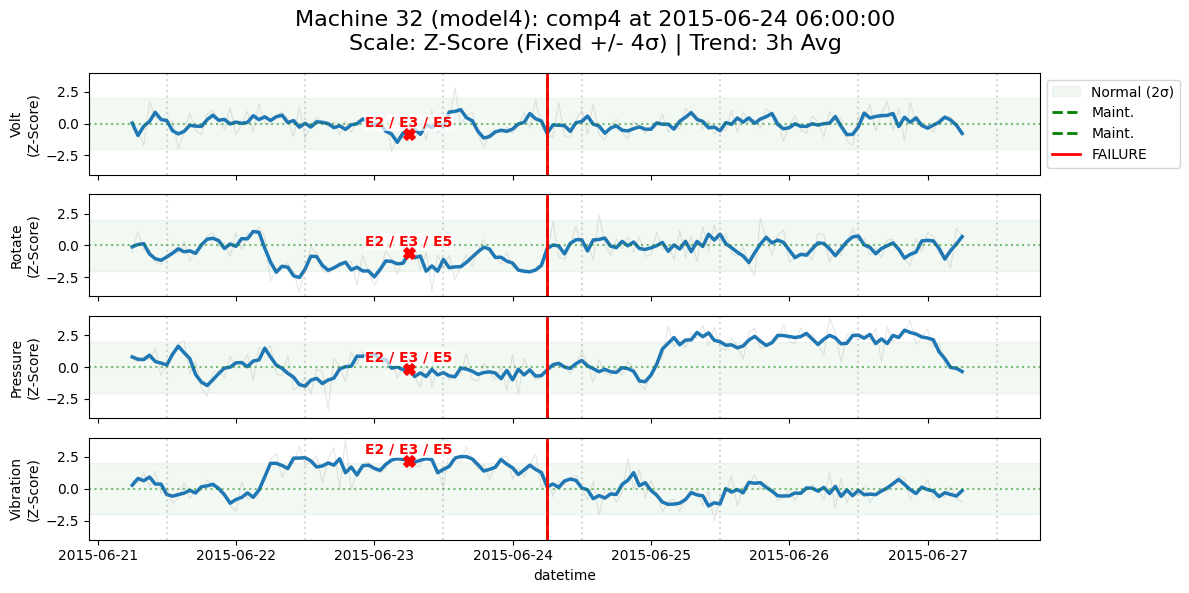

In [4]:
for model_type in ["model1", "model2", "model3", "model4"]:
    for failure_type in ["comp1", "comp2", "comp3", "comp4"]:
        print(f"\n\n=== Visualizing for {model_type} - {failure_type} ===")
        visualize_data(
            telemetry_path="./data/PdM_telemetry.csv",
            errors_path="./data/PdM_errors.csv",
            failures_path="./data/PdM_failures.csv",
            maint_path="./data/PdM_maint.csv",
            machines_path="./data/PdM_machines.csv",
            machine_model=model_type,
            failure_type=failure_type,
            window_hours=72,
            n_examples=1,
            ylim_sigma=4,
            smooth_window=3,
            scale=True
        )